# The Spectrogram

This notebook contains a collection of spectrogram examples.

Usage:
- No code needs to be changed, just select the 'file' of choice in cell 1   
- By setting the flag SAVE_FIG to True, the example plots are saved to file  

In [25]:
# uncomment the pip install command to install pyspch -- it is required!
#
#!pip install git+https://github.com/compi1234/pyspch.git
#
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

# Do the imports #
##################
#
%matplotlib inline
import os,sys 
import numpy as np
import pandas as pd
from IPython.display import display, Audio, HTML, clear_output
import matplotlib.pyplot as plt
#   
import pyspch.sp as Sps
import pyspch.core as Spch
import pyspch.display as Spd
import librosa

# make notebook cells stretch over the full screen
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))
SAVE_FIG = True

## 1.  Waveform + Spectrogram with segmentations

First we load a sample waveform with its available segmentations.  

Then we create a standard spectrogram view of the loaded speech file.
In the top pane we see the sample time waveform and below it a spectrogram.  The waveform shows the signal amplitude at every sample.  The spectrogram is a heatmap representing energy in the time-frequency domain.  In practice we compute a short-time Fourier spectrum every 10msec and collect these as the columns in the spectrogram.

In [21]:
name = "friendly"   # narrowband, male
#name = "expansionist"  # wideband, female
file = "demo/"+name
wavdata, sr = Spch.load_data(file+".wav")
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
segwrd = Spch.load_data(file+ ".wrd")
segphn = Spch.load_data(file+ ".phn")
seggra = Spch.load_data(file+ ".gra")
if seggra is None: seggra = segphn

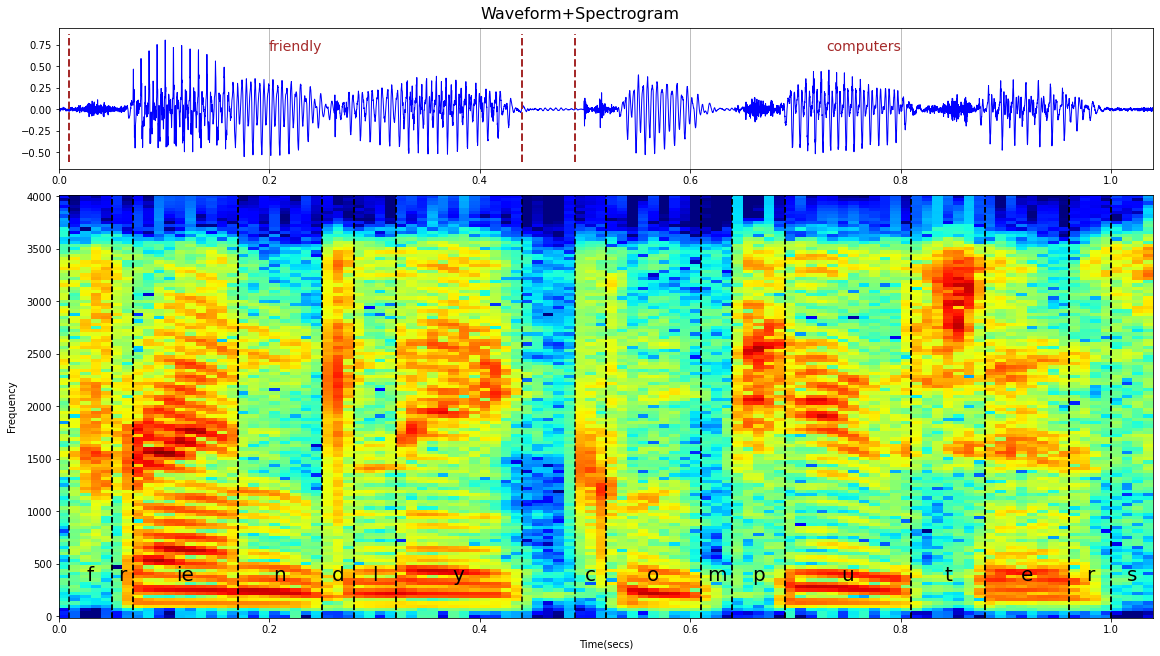

In [22]:
fig=Spd.PlotSpg(spgdata=spg,wavdata=wavdata,sample_rate=sr,ylabel='Frequency',figsize=(16,9))
fig.add_seg_plot(segwrd,iax=0,xrange=fig.axes[0].get_xlim(),ypos=0.9,
                 txtargs={'color':'brown','fontsize':14},lineargs={'color':'brown','linewidth':2}) 
fig.add_seg_plot(seggra,iax=1,ypos=0.1,txtargs={'color':'black','fontsize':20},
                 lineargs={'color':'black','linestyles':'dashed'})
fig.suptitle("Waveform+Spectrogram",fontsize=16);
fig.axes[0].grid(False,axis='y')
display(fig)
display(Audio(data=wavdata,rate=sr))
if SAVE_FIG : fig.savefig("figures/spg_"+file+".png")

# 2. Sliding Window
The figure below gives an illustration of the sliding window approach.
It is typical for a spectrogram to compute a short term spectrum every 10msec (shift).
For each frame the spectrum is computed over a slightly wider window (eg 25 msec) centered around the 10msec center position.
So it is as if we let a window slide over the waveform to cut out the successive frames.
There are some extra signal processing considerations to take care of: to avoid boundary effects in the Fourier computations we use a window that tapers toward the edges such as the Hamming window in this example.   

In the first illustration below, you can adjust 'i1' to give the starting frame number and 'n' to give the number of successive frames in the plot.

In the second illustration you see the sliding window approach for spectrogram generation.  Adjust the frames for the spectrogram selection that is shown and selframes to show the highlighted portion.

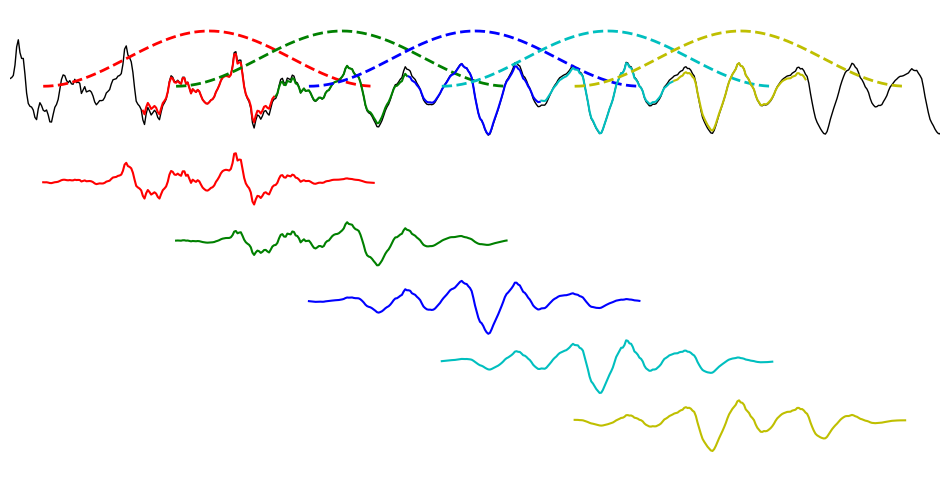

In [26]:
i1=45
if name == 'friendly': i1=15
n=5
shift=0.01
length=0.025
scale=.75
n_shift = int(shift*sr)
n_length = int(length*sr)
# rearrrange the long 1-D data as a sequence of windowed frames
wavshow = wavdata[(i1-1)*n_shift:]
nx = (n_length-n_shift)//2
wav_as_frames = Sps.make_frames(wavdata,pad=nx,n_shift=n_shift,n_length=n_length,preemp=0.0,window='hamming')
window = librosa.filters.get_window('hamming',n_length)

colors = ['r','g','b','c','y','m']
#
fig,ax = plt.subplots(figsize=(12,6))
#ax.plot(wavshow[:(n+2)*n_shift],linewidth=1,color='k')
ax.plot(wavshow,linewidth=1,color='k')
ax.set_xlim([0,n_shift*(n+2)])
ax.axis('off')
ix1 = np.arange(1,n+1)*n_shift
ix2 = ix1+n_shift
for i in range(n):
    xx1 = np.arange(ix1[i],ix2[i])
    xx2 = np.arange(ix1[i]-nx,ix2[i]+nx)
    ax.plot(xx2,scale*window,linestyle='--',linewidth=2,color=colors[i%6])
    ax.plot(xx1,wav_as_frames[nx:nx+n_shift,i1+i],color=colors[i%6])
    ax.plot(xx2,scale*(wav_as_frames[:,i1+i]-(i+1.5)),color=colors[i%6])
if SAVE_FIG: fig.savefig('figures/SlidingWindow'+name+'.png') 

In [27]:
shift=0.01
length=0.025
n_shift = int(shift*sr)
n_length = int(length*sr)
def highlight_frame(fig,iframe=0):    # the animation part
    window = .5*librosa.filters.get_window('hamming',n_length)
    nx = (n_length-n_shift)//2
    pos = iframe*shift
    x0 = pos - (length-shift)/2.
    ix0 = iframe*n_shift - nx
    wav_frame = wavdata[ix0:ix0+n_length]
    xx0 = np.linspace(x0,x0+length,num=n_length,endpoint=False)
    l1, = fig.axes[0].plot(xx0,window,linestyle=':',color='r')  
    l2, = fig.axes[0].plot(xx0,wav_frame,linestyle='-',color='r',lw=3.)  
    highlights = [l1,l2]
    for iax in np.arange(1,len(fig.axes)):
        ax = fig.axes[iax]
        patch = fig.axes[1].axvspan(pos,pos+shift, color='w',alpha=.5,ec='r',lw=5.)   # color='#AAA',alpha=.5,ec='#A00',lw=5.)
        highlights.append(patch)
    return(highlights)

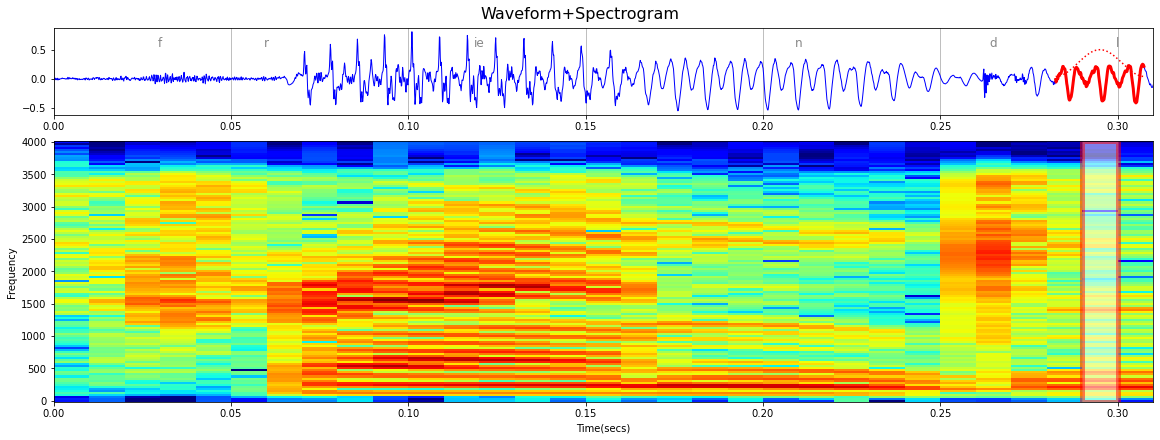

In [32]:
filename = "animations/slwin_"+name+"_"
SAVE_FIG = True
frames=[0,31]
spg = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)
fig=Spd.PlotSpg(spgdata=spg,wavdata=wavdata,sample_rate=sr,ylabel='Frequency',frames=frames,figsize=(16,6))
fig.add_seg_plot(seggra,iax=0,ypos=.82,color='#888',size=12,Lines=False)
fig.suptitle("Waveform+Spectrogram",fontsize=16);
fig.axes[0].grid(False,axis='y')
display(fig)
for iframe in range(frames[0]+1,frames[1]-1): # omit boundary frames for safe plotting 
    clear_output(wait=True)
    x=highlight_frame(fig,iframe=iframe)
    display(fig)
    if SAVE_FIG: fig.savefig(filename+f'{iframe:003}')
    for a in x: a.remove()

In [33]:
#! jupyter nbconvert Tut01_spectrogram.ipynb --to html